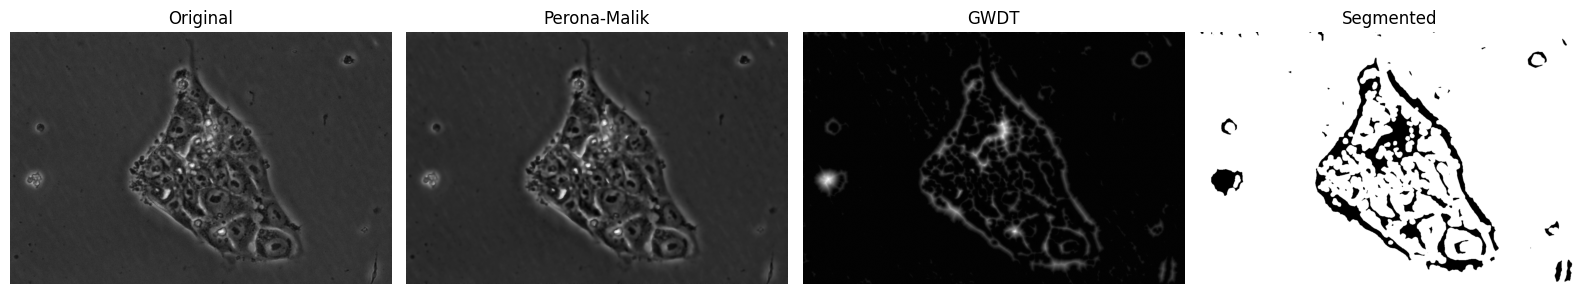

In [2]:
import numpy as np
import cv2
import math
import heapq
import matplotlib.pyplot as plt
from skimage import io
from skimage.measure import label, regionprops
from numba import jit, prange

### --- Perona-Malik Diffusion --- ###
def compute_gradients(image):
    grad_north = np.zeros_like(image)
    grad_south = np.zeros_like(image)
    grad_east = np.zeros_like(image)
    grad_west = np.zeros_like(image)

    grad_north[:-1] = image[1:] - image[:-1]
    grad_south[1:] = image[:-1] - image[1:]
    grad_east[:, :-1] = image[:, 1:] - image[:, :-1]
    grad_west[:, 1:] = image[:, :-1] - image[:, 1:]
    return grad_north, grad_south, grad_east, grad_west

def perona_malik_conduction(gradients, kappa, method='quadratic'):
    if method == 'quadratic':
        return [np.exp(-(g / kappa)**2) for g in gradients]
    elif method == 'exponential':
        return [1. / (1. + (g / kappa)**2) for g in gradients]
    raise ValueError("Invalid conduction method.")

@jit(nopython=True, parallel=True)
def update_image(image, gradients, conductance, delta_t):
    result = np.zeros_like(image)
    for i in prange(1, image.shape[0] - 1):
        for j in prange(1, image.shape[1] - 1):
            total = 0.0
            for d in range(4):
                total += conductance[d][i, j] * gradients[d][i, j]
            result[i, j] = total  # Assign the total to result[i, j]
    return np.clip(image + delta_t * result, 0, 255)


def perona_malik(image, iterations=20, delta_t=0.1, kappa=20, method='quadratic'):
    image = image.astype(np.float64)
    for _ in range(iterations):
        grads = compute_gradients(image)
        conds = perona_malik_conduction(grads, kappa, method)
        image = update_image(image, grads, conds, delta_t)
    return image.astype(np.uint8)

### --- Grey Weighted Distance Transform --- ###
INF = np.finfo(np.float32).max
ALIVE, TRIAL, FAR = -1, 0, 1

def initialize_gwdt(image):
    mean_val = np.mean(image)
    state = np.full_like(image, FAR, dtype=np.int8)
    dist_map = np.full_like(image, INF, dtype=np.float32)
    mask = image < mean_val
    dist_map[mask] = image[mask].astype(float)
    state[mask] = ALIVE
    return state, dist_map

def gwdt(image):
    state, dist = initialize_gwdt(image)
    pq = []
    rows, cols = image.shape

    for i in range(1, rows - 1):
        for j in range(1, cols - 1):
            if state[i, j] == FAR and np.any(state[i-1:i+2, j-1:j+2] == ALIVE):
                state[i, j] = TRIAL
                dist[i, j] = float(image[i, j])
                heapq.heappush(pq, (dist[i, j], i, j))

    while pq:
        d, i, j = heapq.heappop(pq)
        for di, dj in [(-1,0), (1,0), (0,-1), (0,1), (-1,-1), (-1,1), (1,-1), (1,1)]:
            ni, nj = i + di, j + dj
            if 0 <= ni < rows and 0 <= nj < cols:
                cost = d + image[ni, nj] * math.hypot(di, dj)
                if dist[ni, nj] > cost:
                    dist[ni, nj] = cost
                    state[ni, nj] = TRIAL
                    heapq.heappush(pq, (cost, ni, nj))

    dist[dist == INF] = 0
    dist = (dist / (np.max(dist) + 1)) * 255 if np.max(dist) > 0 else np.zeros_like(dist)
    return dist.astype(np.uint8)

### --- Chan-Vese Active Contour --- ###
def apply_operation(matrix, op):
    func = {'atan': math.atan, 'sqrt': math.sqrt}[op]
    return np.vectorize(func)(matrix)

def CV(LSF, img, mu, nu, eps, step):
    Drc = (eps / math.pi) / (eps**2 + LSF**2)
    Hea = 0.5 * (1 + (2 / math.pi) * apply_operation(LSF / eps, "atan"))
    Iy, Ix = np.gradient(LSF)
    s = apply_operation(Ix**2 + Iy**2, "sqrt")
    Nx, Ny = Ix / (s + 1e-6), Iy / (s + 1e-6)
    _, Nxx = np.gradient(Nx)
    Nyy, _ = np.gradient(Ny)
    curv = Nxx + Nyy

    length_term = nu * Drc * curv
    laplace = cv2.Laplacian(LSF, cv2.CV_64F)
    penalty_term = mu * (laplace - curv)

    C1 = np.sum(Hea * img) / np.sum(Hea)
    C2 = np.sum((1 - Hea) * img) / np.sum(1 - Hea)
    cv_term = Drc * (-(img - C1)**2 + (img - C2)**2)

    return LSF + step * (length_term + penalty_term + cv_term)

def has_converged(LSF, LSF_next, prev_area, seg_patch, delta=1e-3, t_area=10):
    lsf_change = np.linalg.norm(LSF_next - LSF)
    area = np.sum(LSF_next > 0)
    area_change = abs(area - prev_area)

    # Criteria: LSF change is small AND area change is small OR intersection occurs
    return (lsf_change < delta and area_change < t_area) or intersects(LSF_next, seg_patch)


def intersects(LSF, mask):
    return np.any(np.logical_and(LSF > 0, mask > 0))


### --- Combined Segmentation Method --- ###
def segment(image, mask, num_iter=100, mu=1, nu=None, eps=1, step=0.1):
    if nu is None:
        nu = 0.003 * 255**2

    final_seg = np.zeros_like(image, dtype=np.uint8)
    labeled_mask = label(mask)

    for region in regionprops(labeled_mask):
        minr, minc, maxr, maxc = region.bbox
        patch = image[minr:maxr, minc:maxc]
        mask_patch = mask[minr:maxr, minc:maxc]
        seg_patch = final_seg[minr:maxr, minc:maxc]

        patch_filtered = perona_malik(patch, iterations=30)
        patch_gwdt = gwdt(patch_filtered)
        working_patch = patch_gwdt.astype(np.float64)

        LSF = np.ones_like(working_patch)
        LSF[mask_patch > 0] = -1
        LSF = -LSF
        prev_LSF = LSF.copy()

        prev_area = np.sum(LSF > 0)
        for k in range(num_iter):
            LSF_next = CV(LSF, working_patch, mu, nu, eps, step)

            if has_converged(LSF, LSF_next, prev_area, seg_patch):
               break

            LSF, prev_area = LSF_next, np.sum(LSF_next > 0)



        final_seg[minr:maxr, minc:maxc] |= (LSF > 0).astype(np.uint8)

    return image, patch_filtered, patch_gwdt, final_seg


### --- Main Execution --- ###
def main():
    image_path = 'genimage.tif'
    mask_path = 'markerimage.tif'

    image = io.imread(image_path, as_gray=True)
    mask = (io.imread(mask_path, as_gray=True) > 0).astype(np.uint8)

    original, pm_result, gwdt_result, segmented = segment(image, mask)

    io.imsave('segmented_result.png', (segmented * 255).astype(np.uint8))

    titles = ['Original', 'Perona-Malik', 'GWDT', 'Segmented']
    images = [original, pm_result, gwdt_result, segmented]
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    for ax, img, title in zip(axes, images, titles):
        ax.imshow(img, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()


